In [1]:
import nltk
import torch
import torchvision
import numpy as np
import string
import unicodedata
import torch.nn as nn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import brown
from sklearn.model_selection import train_test_split, KFold

In [2]:
# important constants
char_embedding_dim = 30
word_embedding_dim = 100
max_word_len = 40
dropout_prob = 0.5
num_cnn_filter = 30
char_kernel_size = 3
rnn_hidden_dim = 100
word_embedding_path = 'glove.6B/glove.6B.{}d.txt'.format(word_embedding_dim)
lr = 0.01
lr_decay = 0.05
min_epoches = 3
momentum = 0.9
batch_size = 10

In [3]:
# setting the device to gpu if cuda is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# datastructure for storing the id and val mapping
class unique_dict:
    def __init__(self):
        self.id = 0
        self.id2val = dict()
        self.val2id = dict()
        self.vals = set()
        
    def get_length(self):
        return self.id
    
    def store(self, val):
        self.id2val[self.id] = val
        self.val2id[val] = self.id
        self.vals.add(val)
        self.id += 1
    
    def fetch(self, key, by='id'):
        if by == 'id':
            return self.id2val[key]
        elif key in self.vals:
            return self.val2id[key]
        else:
            return None

In [9]:
# initializing character unique_dict for ascii characters only
def generate_unique_characters():
    char_list = ''.join([chr(i) for i in range(128)])
    characters = unique_dict()
    for char in char_list:
        characters.store(char)
    return characters

# intializes the word unique_dict and embedding matrix
def generate_words_embedding(embedding_path):
    words = unique_dict()
    word_embedding = list()
    
    with open(embedding_path, 'rb') as embedding_file:
        for encoded_line in tqdm(embedding_file):
            line = encoded_line.decode().split()
            words.store(line[0])
            embedding = np.array(line[1:]).astype(np.float)
            word_embedding.append(embedding)
    
    other_embedding = np.random.rand(2, word_embedding_dim)
            
    return words, np.vstack([np.array(word_embedding), other_embedding])

def generate_dataset(tags):
    tagged_sent = brown.tagged_sents(tagset='universal')
    word_sequences = [[word for (word, tag) in sent] for sent in tagged_sent]
    tag_sequences = [[tags.fetch(tag, 'val') for (word, tag) in sent] for sent in tagged_sent]
    return word_sequences, tag_sequences

def generate_unique_tags():
    tagset = set([tag for [word, tag] in brown.tagged_words(tagset='universal')])
    tags = unique_dict()
    tags.store('dummy')
    for tag in tagset:
        if tags.fetch(tag, 'val') == None:
            tags.store(tag)
    return tags

# character level word encoder
class Encoder(nn.Module):
    def __init__(self, characters, words, word_embedding):
        super(Encoder, self).__init__()
        self.characters = characters
        self.words = words
        
        # embedding layer utils
        self.word_embedding = torch.from_numpy(word_embedding)
        self.char_embedding = nn.Embedding(characters.id + 2, char_embedding_dim) # unk char => 128, pad char => 129 
        nn.init.uniform_(self.char_embedding.weight, a=-(3/char_embedding_dim)**0.5, b=(3/char_embedding_dim)**0.5)
        
        # dropout utils
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # character convolution
        self.convolution = nn.Conv1d(
            in_channels=char_embedding_dim,
            out_channels=char_embedding_dim * num_cnn_filter,
            kernel_size=char_kernel_size,
            groups=char_embedding_dim
        )
        nn.init.xavier_uniform_(self.convolution.weight, gain=1.0)
        nn.init.zeros_(self.convolution.bias)
    
    def forward(self, word_sequences):
        batch_count = len(word_sequences)
        seq_len = [len(seq) for seq in word_sequences]
        max_seq_len = max(seq_len)
        expanded_seq = [[[char for char in word] for word in seq] for seq in word_sequences]
        word_seq_tensor = torch.zeros(batch_count, max_seq_len, max_word_len, dtype=torch.long, device=device)
        
        # converting list of sequences of list of words of list of characters to corresponding ids
        for batch_id, curr_seq in enumerate(expanded_seq):
            curr_seq_id = list()
            for word in curr_seq:
                word_id = [self.characters.fetch(char, 'val') or self.characters.id for char in word]
                word_id = torch.LongTensor(word_id).to(device)
                
                # center padding for the word
                pad = [(max_word_len - len(word)) // 2, (max_word_len - len(word) + 1) // 2]
                word_id = nn.functional.pad(word_id, pad, value=self.characters.id + 1)
                curr_seq_id.append(word_id)
            
            # appending the sequence to the word_seq_tensor
            curr_seq_tensor = torch.zeros(len(curr_seq_id), max_word_len, dtype=torch.long, device=device)
            curr_seq_tensor = torch.stack(curr_seq_id)
            word_seq_tensor[batch_id, :curr_seq_tensor.shape[0], :] = curr_seq_tensor
        
        # generating embeddings character level
        word_seq_embeddings = self.char_embedding(word_seq_tensor)
        word_seq_embeddings = word_seq_embeddings.permute(0, 1, 3, 2)
        
        # applying the dropout
        word_seq_embeddings = self.dropout(word_seq_embeddings)
        
        # convolution and max pooling
        max_pooling_output = torch.zeros(
            word_seq_embeddings.shape[0],
            word_seq_embeddings.shape[1],
            char_embedding_dim * num_cnn_filter,
            dtype=torch.float,
            device=device,
        )
        for word_id in range(max_seq_len):
            max_pooling_output[:, word_id, :], _ = torch.max(self.convolution(word_seq_embeddings[:, word_id, :, :]), dim=2)
            
        # indexing the words according to the vocabulary
        seq_word_indices = torch.ones(batch_count, max_seq_len, dtype=torch.int32, device=device) * (self.word_embedding.shape[0] - 1)
        for (row_index, seq) in enumerate(word_sequences):
            for (column_index, word) in enumerate(seq):
                seq_word_indices[row_index, column_index] = self.words.fetch(word.lower(), 'val') or (self.word_embedding.shape[0] - 2)
        
        # generating the word embedding
        word_embeddings_glove = torch.zeros(batch_count, max_seq_len, word_embedding_dim, device=device)
        for row_index in range(seq_word_indices.shape[0]):
            for column_index in range(seq_word_indices.shape[1]):
                word_embeddings_glove[row_index, column_index, :] = self.word_embedding[seq_word_indices[row_index, column_index]]
        word_embeddings_glove = self.dropout(word_embeddings_glove)
        
        # stacking the character level and word level embedding and returning the seq_le
        return torch.cat([max_pooling_output, word_embeddings_glove], dim=2), seq_len

# birnn custom class
class BilstmCustom(nn.Module):
    def __init__(self):
        super(BilstmCustom, self).__init__()
        
        # rnn layer initializations
        self.rnn = nn.LSTM(
            input_size=char_embedding_dim * num_cnn_filter + word_embedding_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        nn.init.xavier_uniform_(self.rnn.weight_hh_l0)
        nn.init.xavier_uniform_(self.rnn.weight_hh_l0_reverse)
        nn.init.xavier_uniform_(self.rnn.weight_ih_l0)
        nn.init.xavier_uniform_(self.rnn.weight_ih_l0_reverse)
        self.rnn.bias_hh_l0.data.fill_(0)
        self.rnn.bias_hh_l0_reverse.data.fill_(0)
        self.rnn.bias_ih_l0.data.fill_(0)
        self.rnn.bias_ih_l0_reverse.data.fill_(0)
        self.h_0 = torch.zeros(2, batch_size, rnn_hidden_dim, device=device, requires_grad=False)
        self.c_0 = torch.zeros(2, batch_size, rnn_hidden_dim, device=device, requires_grad=False)
        
        # setting a specific section of the bias = 1
        for names in self.rnn._all_weights:
            for name in filter(lambda n: 'bias' in n, names):
                bias = getattr(self.rnn, name)
                n = bias.size(0)
                start, end = n // 4, n // 2
                bias.data[start:end].fill_(1.)
        
    # sorts the sequence in the decreasing order, also returns the indexes in reverse order
    def reverse_seq_len_sort(self, seq_len_list):
        data_num = len(seq_len_list)
        sort_indices = sorted(range(len(seq_len_list)), key=seq_len_list.__getitem__, reverse=True)
        reverse_sort_indices = [-1 for _ in range(data_num)]
        for i in range(data_num):
            reverse_sort_indices[sort_indices[i]] = i
        sort_index = torch.tensor(sort_indices, dtype=torch.long).to(device)
        reverse_sort_index = torch.tensor(reverse_sort_indices, dtype=torch.long).to(device)
        return sorted(seq_len_list, reverse=True), sort_index, reverse_sort_index
    
    # used for packing the sequences
    # returns the packed input tensor along with reverse_sort_index to return back original order
    def pack(self, input_tensor, seq_len_list):
        sorted_seq, sort_index, reverse_sort_index = self.reverse_seq_len_sort(seq_len_list)
        input_tensor_sorted = torch.index_select(input_tensor, dim=0, index=sort_index)
        return nn.utils.rnn.pack_padded_sequence(input_tensor_sorted, lengths=sorted_seq, batch_first=True), reverse_sort_index
    
    # used to nullify the effect of the above
    def unpack(self, output_packed_tensor, max_seq_len, reverse_sort_index):
        output_tensor, _ = nn.utils.rnn.pad_packed_sequence(output_packed_tensor, batch_first=True, total_length=max_seq_len)
        output_original_tensor = torch.index_select(output_tensor, dim=0, index=reverse_sort_index)
        return output_original_tensor
    
    def forward(self, seq_word_embeddings, seq_len):
        num_batch, max_seq_len, _ = seq_word_embeddings.shape
        seq_word_embeddings_packed, reverse_sort_index = self.pack(seq_word_embeddings, seq_len)
        output_packed_tensor, (h_0, c_0) = self.rnn(seq_word_embeddings_packed, (self.h_0, self.c_0))
        self.h_0 = h_0.detach()
        self.c_0 = c_0.detach()
        return self.unpack(output_packed_tensor, max_seq_len, reverse_sort_index)
    
class CnnLstm(nn.Module):
    def __init__(self, encoder, biLstmCustom, tags):
        super(CnnLstm, self).__init__()
        
        # encoders and rnn layers
        self.encoder = encoder
        self.biLstmCustom = biLstmCustom

        # a drop out layer
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # linear layer
        self.linear = nn.Linear(in_features=rnn_hidden_dim * 2, out_features=tags.id)
        self.log_soft_max = nn.LogSoftmax(dim=1)
        
        # loss layer
        self.nll_loss = nn.NLLLoss(ignore_index=0)
        
    def forward(self, word_sequences):
        # deriving the encodings at character level and word level
        seq_word_embeddings, seq_len = self.encoder(word_sequences)
        
        # applying the rnn layer
        rnn_output_tensor = self.biLstmCustom(seq_word_embeddings, seq_len)
        rnn_output_tensor = self.dropout(rnn_output_tensor)
        
        # application of linear layer
        linear_output = self.linear(rnn_output_tensor)
        linear_output_log = self.log_soft_max(linear_output.permute(0, 2, 1))
        return linear_output_log, seq_len
    
    def cross_entropy_loss(self, mini_batch_word_sequences, mini_batch_tag_sequences):
        output_log_likelihood, _ = self.forward(mini_batch_word_sequences)
        loss = self.nll_loss(output_log_likelihood, mini_batch_tag_sequences)
        return loss
    
# to analyze the confusion matrix (to be tested)
def analyze_confusion(confusion_matrix, tag_histogram, tags, data='test'):
    
    # accuracy computation
    total_examples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    print('The overall accuracy of the bilstm model is:', correct_predictions * 100 / total_examples)
    
    # storing the confusion matrix in the form of csv file
    tag_list = [tags.fetch(i, 'id') for i in range(1, tags.id)]
    confusion_df = pd.DataFrame(confusion_matrix, index=tag_list, columns=tag_list)
    confusion_df.to_csv('bilstm_confusion_matrix_' + data + '.csv')
    
    # plotting the heat map
    plt.figure(figsize = (20, 20))
    confusion_figure = sns.heatmap(confusion_matrix, annot=True, xticklabels=tag_list, yticklabels=tag_list)
    plt.savefig('bilstm_confusion_figure_' + data + '.png')
    
    # per POS tag statistics
    per_pos_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
    for tag_id in range(confusion_matrix.shape[0]):
        per_pos_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
        per_pos_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
        per_pos_dict['tag'].append(tags.fetch(tag_id + 1, 'id'))
        per_pos_dict['f1-score'].append(2 * per_pos_dict['precision'][tag_id] * per_pos_dict['recall'][tag_id] / (per_pos_dict['recall'][tag_id] + per_pos_dict['precision'][tag_id]))
    per_pos_df = pd.DataFrame(per_pos_dict)
    per_pos_df.to_csv('bilstm_per_pos_accuracy_' + data + '.csv')
    
    # scatter plot for frequency vs f1-score for every tag
    tag_f1_score = np.nan_to_num(per_pos_dict['f1-score'])
    plt.figure()
    plt.scatter(tag_histogram, tag_f1_score)
    plt.title('Relative Frequency vs f1-score scatter plot')
    plt.xlabel('Relative Frequency of tag')
    plt.ylabel('F1 score')
    plt.savefig('bilstm_scatter_plot_' + data + '.png')

In [6]:
tags = generate_unique_tags()
characters = generate_unique_characters()
words, word_embedding = generate_words_embedding(word_embedding_path)

400001it [01:09, 5784.37it/s]


In [7]:
encoder = Encoder(characters, words, word_embedding).to(device)
bilstm = BilstmCustom().to(device)
cnnLstm = CnnLstm(encoder, bilstm, tags).to(device)

In [7]:
test = [['Hello', 'everyone', '!'], ['How', 'are', 'you', '?'], ['Hello', 'everyone', '!']]

In [9]:
word_sequences, tag_sequences = generate_dataset(tags)
word_sequences_train, word_sequences_test, tag_sequences_train, tag_sequences_test = train_test_split(word_sequences, tag_sequences)

In [22]:
optimizer = torch.optim.SGD(cnnLstm.parameters(), lr=lr, momentum=momentum)
for epoch in range(min_epoches):
    for i in tqdm(range(0, len(word_sequences_train), batch_size - 1)):        
        # optimizer gradient flushing
        optimizer.zero_grad()
        
        # sampling minibatches
        word_sequences_train_minibatch = word_sequences_train[i: i + batch_size]
        tag_sequences_train_minibatch = tag_sequences_train[i: i + batch_size]
        
        
        if len(word_sequences) == batch_size:
            # padding the ground truth
            max_seq_len = max([len(tag_seq) for tag_seq in tag_sequences_train_minibatch])
            tag_tensor = torch.zeros(len(tag_sequences_train_minibatch), max_seq_len, dtype=torch.long, device=device)
            for row_index, tag_seq in enumerate(tag_sequences_train_minibatch):
                for column_index, tag_id in enumerate(tag_seq):
                    tag_tensor[row_index, column_index] = tag_id

            # cross entropy loss computation
            ce_loss = cnnLstm.cross_entropy_loss(word_sequences_train_minibatch, tag_tensor)
            ce_loss.backward(retain_graph=True)
            optimizer.step()
        
        # printing the loss
        if i % 5000 == 0:
            print('Epoch {}, Iteration {}: {}'.format(epoch, i, ce_loss))

In [23]:
confusion_matrix = torch.zeros(tags.id - 1, tags.id - 1, dtype=torch.int32, device=device)

# filling the entries in confusian matrix
with torch.no_grad():
    for i in (range(0, len(word_sequences_test), batch_size)):
        
        # sampling minibatches
        word_sequences_test_minibatch = word_sequences_test[i: i + batch_size]
        tag_sequences_test_minibatch = tag_sequences_test[i: i + batch_size]

        # finding the model predictions
        output_log_likelihood, _ = cnnLstm.forward(word_sequences_test_minibatch)
        _, tag_pred_sequences_minibatch = torch.max(output_log_likelihood, dim=1)

        for row_index, seq in enumerate(tag_sequences_test_minibatch):
            for col_index, tag_id in enumerate(seq):
                if tag_id != 0 and tag_pred_sequences_minibatch[row_index, col_index] != 0:
                    confusion_matrix[tag_pred_sequences_minibatch[row_index, col_index] - 1, tag_id - 1] += 1

In [20]:
tag_histogram = np.zeros(tags.id - 1)
for tag_seq in tag_sequences:
    for tag_id in tag_seq:
        tag_histogram[tag_id - 1] += 1
tag_histogram = tag_histogram / np.sum(tag_histogram)

The overall accuracy of the bilstm model is: 80.43234860496815


C:\Users\Inderjeet\anaconda3\lib\site-packages\ipykernel_launcher.py:242: RuntimeWarning: invalid value encountered in long_scalars


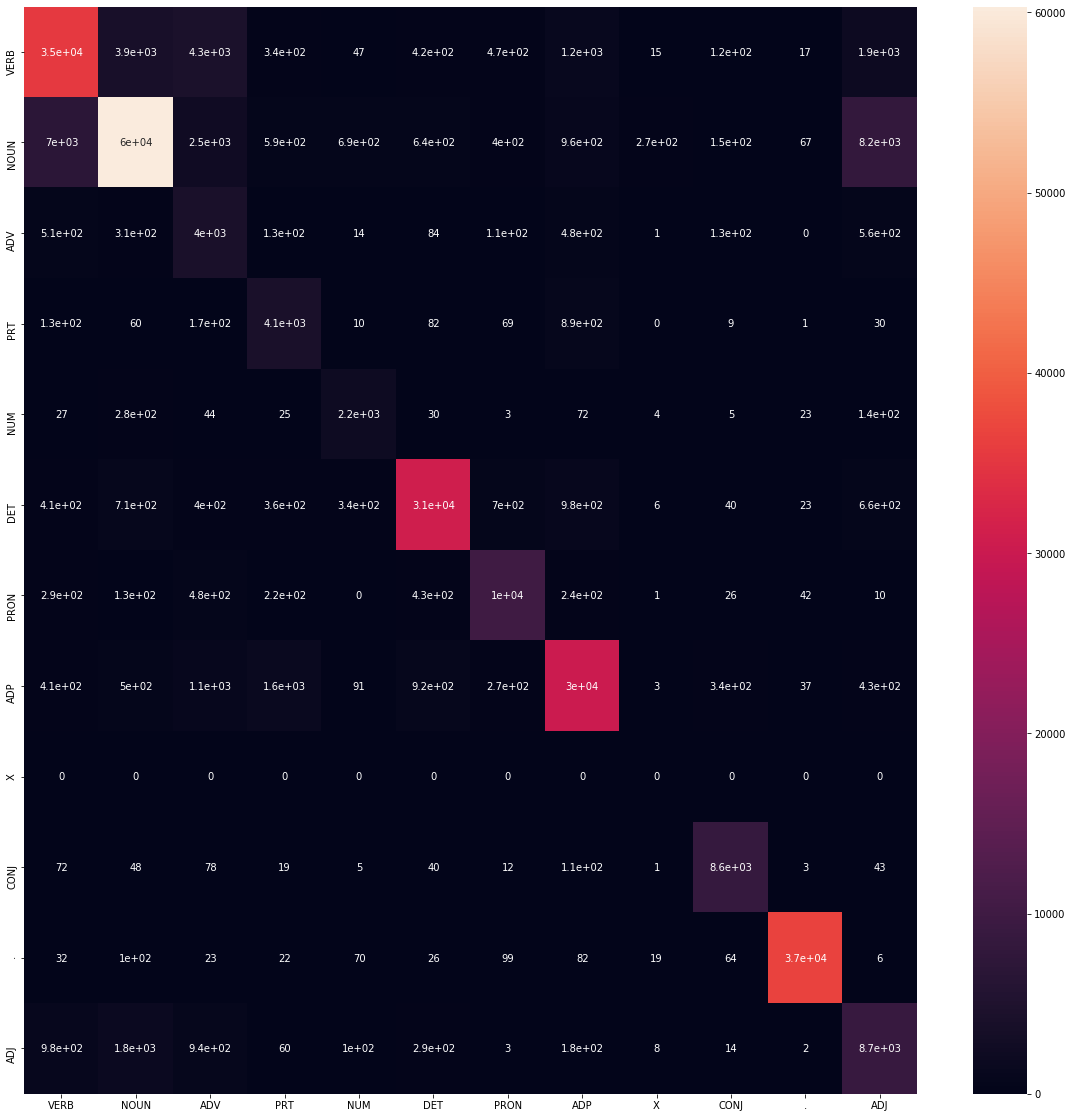

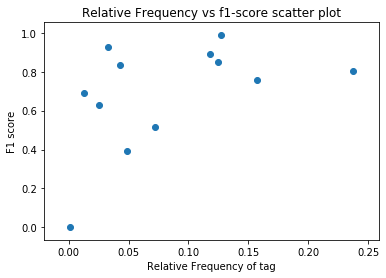

In [21]:
analyze_confusion(confusion_matrix.to('cpu').numpy(), tag_histogram, tags, data='test')

In [10]:
# confusion matrix initialization
confusion_matrix_train = torch.zeros(tags.id - 1, tags.id - 1, dtype=torch.int32, device=device)
confusion_matrix_test = torch.zeros(tags.id - 1, tags.id - 1, dtype=torch.int32, device=device)

# Partitioning the dataset
corpus = np.array(brown.tagged_sents(tagset='universal'))
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(corpus)

# KFOLD Starts
for train_index, test_index in kf.split(corpus):
    
    # dataset parsing
    train_corpus = corpus[train_index]
    test_corpus = corpus[test_index]
    word_sequences_train = [[word for (word, tag) in sent] for sent in train_corpus]
    tag_sequences_train = [[tags.fetch(tag, 'val') for (word, tag) in sent] for sent in train_corpus]
    word_sequences_test = [[word for (word, tag) in sent] for sent in test_corpus]
    tag_sequences_test = [[tags.fetch(tag, 'val') for (word, tag) in sent] for sent in test_corpus]
    
    # model initialization
    encoder = Encoder(characters, words, word_embedding).to(device)
    bilstm = BilstmCustom().to(device)
    cnnLstm = CnnLstm(encoder, bilstm, tags).to(device)
    optimizer = torch.optim.SGD(cnnLstm.parameters(), lr=lr, momentum=momentum)
    
    # training begins
    for epoch in range(min_epoches):
        for i in tqdm(range(0, len(word_sequences_train), batch_size - 1)):        
            # optimizer gradient flushing
            optimizer.zero_grad()

            # sampling minibatches
            word_sequences_train_minibatch = word_sequences_train[i: i + batch_size]
            tag_sequences_train_minibatch = tag_sequences_train[i: i + batch_size]


            if len(word_sequences_train_minibatch) == batch_size:
                # padding the ground truth
                max_seq_len = max([len(tag_seq) for tag_seq in tag_sequences_train_minibatch])
                tag_tensor = torch.zeros(len(tag_sequences_train_minibatch), max_seq_len, dtype=torch.long, device=device)
                for row_index, tag_seq in enumerate(tag_sequences_train_minibatch):
                    for column_index, tag_id in enumerate(tag_seq):
                        tag_tensor[row_index, column_index] = tag_id

                # cross entropy loss computation
                ce_loss = cnnLstm.cross_entropy_loss(word_sequences_train_minibatch, tag_tensor)
                ce_loss.backward()
                optimizer.step()

            # printing the loss
            if i % 5000 == 0:
                print('Epoch {}, Iteration {}: {}'.format(epoch, i, ce_loss))
                
    # updating the confusion matrix test
    with torch.no_grad():
        for i in (range(0, len(word_sequences_test), batch_size)):

            # sampling minibatches
            word_sequences_test_minibatch = word_sequences_test[i: i + batch_size]
            tag_sequences_test_minibatch = tag_sequences_test[i: i + batch_size]

            if len(word_sequences_test_minibatch) == batch_size:
                # finding the model predictions
                output_log_likelihood, _ = cnnLstm.forward(word_sequences_test_minibatch)
                _, tag_pred_sequences_minibatch = torch.max(output_log_likelihood, dim=1)

                for row_index, seq in enumerate(tag_sequences_test_minibatch):
                    for col_index, tag_id in enumerate(seq):
                        if tag_id != 0 and tag_pred_sequences_minibatch[row_index, col_index] != 0:
                            confusion_matrix_test[tag_pred_sequences_minibatch[row_index, col_index] - 1, tag_id - 1] += 1
                        
        
        # updating the same for train
        for i in (range(0, len(word_sequences_train), batch_size)):

            # sampling minibatches
            word_sequences_train_minibatch = word_sequences_train[i: i + batch_size]
            tag_sequences_train_minibatch = tag_sequences_train[i: i + batch_size]

            if len(word_sequences_train_minibatch) == batch_size:
                # finding the model predictions
                output_log_likelihood, _ = cnnLstm.forward(word_sequences_train_minibatch)
                _, tag_pred_sequences_minibatch = torch.max(output_log_likelihood, dim=1)

                for row_index, seq in enumerate(tag_sequences_train_minibatch):
                    for col_index, tag_id in enumerate(seq):
                        if tag_id != 0 and tag_pred_sequences_minibatch[row_index, col_index] != 0:
                            confusion_matrix_train[tag_pred_sequences_minibatch[row_index, col_index] - 1, tag_id - 1] += 1
                            
                            
    # deleting the models
    del encoder
    del bilstm
    del cnnLstm
    del optimizer

  0%|          | 1/5097 [00:00<26:05,  3.26it/s]

Epoch 0, Iteration 0: 2.6509718894958496


 98%|█████████▊| 5001/5097 [24:31<00:22,  4.31it/s]

Epoch 0, Iteration 45000: 0.6000776290893555


  0%|          | 1/5097 [00:00<30:09,  2.82it/s]

Epoch 1, Iteration 0: 0.5956970453262329


 98%|█████████▊| 5002/5097 [29:03<00:16,  5.94it/s]

Epoch 1, Iteration 45000: 0.443499356508255


  0%|          | 1/5097 [00:00<22:01,  3.86it/s]

Epoch 2, Iteration 0: 0.46761536598205566


 98%|█████████▊| 5001/5097 [21:18<00:15,  6.06it/s] 

Epoch 2, Iteration 45000: 0.39931073784828186


  0%|          | 1/5097 [00:00<28:58,  2.93it/s]

Epoch 0, Iteration 0: 2.52113938331604


 98%|█████████▊| 5002/5097 [19:29<00:16,  5.73it/s]

Epoch 0, Iteration 45000: 0.6468234062194824


  0%|          | 1/5097 [00:00<31:20,  2.71it/s]

Epoch 1, Iteration 0: 0.5873337984085083


 98%|█████████▊| 5002/5097 [19:34<00:16,  5.65it/s]

Epoch 1, Iteration 45000: 0.5890250205993652


  0%|          | 1/5097 [00:00<33:53,  2.51it/s]

Epoch 2, Iteration 0: 0.4281282126903534


 98%|█████████▊| 5002/5097 [19:39<00:16,  5.68it/s]

Epoch 2, Iteration 45000: 0.5017830729484558


  0%|          | 1/5097 [00:00<22:58,  3.70it/s]

Epoch 0, Iteration 0: 2.5651838779449463


 98%|█████████▊| 5001/5097 [20:58<00:22,  4.25it/s]

Epoch 0, Iteration 45000: 0.6162698268890381


  0%|          | 1/5097 [00:00<23:48,  3.57it/s]

Epoch 1, Iteration 0: 0.5395935773849487


 98%|█████████▊| 5001/5097 [20:38<00:19,  4.90it/s]

Epoch 1, Iteration 45000: 0.4175141155719757


  0%|          | 1/5097 [00:00<22:57,  3.70it/s]

Epoch 2, Iteration 0: 0.4297086000442505


 98%|█████████▊| 5002/5097 [19:23<00:19,  4.80it/s]

Epoch 2, Iteration 45000: 0.4446398913860321


  0%|          | 1/5097 [00:00<20:44,  4.09it/s]

Epoch 0, Iteration 0: 2.5730066299438477


 98%|█████████▊| 5002/5097 [19:54<00:15,  6.32it/s]

Epoch 0, Iteration 45000: 0.7073525190353394


  0%|          | 1/5097 [00:00<25:55,  3.28it/s]

Epoch 1, Iteration 0: 0.549323558807373


 15%|█▍        | 750/5097 [03:05<19:58,  3.63it/s]

RuntimeError: transform: failed to synchronize: cudaErrorLaunchFailure: unspecified launch failure

In [ ]:
tag_histogram = np.zeros(tags.id - 1)
for tag_seq in tag_sequences:
    for tag_id in tag_seq:
        tag_histogram[tag_id - 1] += 1
tag_histogram = tag_histogram / np.sum(tag_histogram)

In [ ]:
analyze_confusion(confusion_matrix_test.to('cpu').numpy(), tag_histogram, tags, data='test')